# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных**

Данные находятся в файле autos.csv.

Признаки:

•	DateCrawled — дата скачивания анкеты из базы

•	VehicleType — тип автомобильного кузова

•	RegistrationYear — год регистрации автомобиля

•	Gearbox — тип коробки передач

•	Power — мощность (л. с.)

•	Model — модель автомобиля

•	Kilometer — пробег (км)

•	RegistrationMonth — месяц регистрации автомобиля

•	FuelType — тип топлива

•	Brand — марка автомобиля

•	Repaired — была машина в ремонте или нет

•	DateCreated — дата создания анкеты

•	NumberOfPictures — количество фотографий автомобиля

•	PostalCode — почтовый индекс владельца анкеты (пользователя)

•	LastSeen — дата последней активности пользователя

Целевой признак:

Price — цена (евро)


**План работы:**

Шаг 1.	Подготовка данных

- Загрузить данные, путь к файлу: /datasets/autos.csv.
- Изучить данные. 
- Заполнить пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалить их.

Шаг 2.	Обучение моделей 

- Подготовить выборки для обучения моделей.
- Обучить разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.

Шаг 3.	Анализ моделей

- Проанализировать время обучения, время предсказания и качество моделей.
- Опираясь на критерии заказчика, выбрать лучшую модель, проверить её качество на тестовой выборке.


## Подготовка данных

### Импортируем библиотеки

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import time
import warnings


from phik.report import plot_correlation_matrix
from phik import report


from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline
# загружаем классы для подготовки данных
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)
from sklearn.compose import ColumnTransformer
# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.metrics import mean_squared_error

# импортируем класс RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV
#from optuna.integration import OptunaSearchCV 

# загружаем нужные модели
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.svm import SVC
from lightgbm import LGBMRegressor

warnings.filterwarnings("ignore")

### Загрузим данные. 

In [2]:
auto_data = pd.read_csv('autos.csv', sep = ',')
auto_data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Предобработка данных.

**Проверим наличие пропусков в данных.**

In [3]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Есть пропуски в столбцах VehicleType,  Gearbox,  FuelType,  Repaired.

**Проверим наличие дубликатов в данных.**

Проверим, есть ли явные дубликаты.

In [4]:
print("Количество явных дубликатов в auto_data:", auto_data.duplicated().sum())

Количество явных дубликатов в auto_data: 4


Удалим дубликаты, так как очень маловероятно, что есть одинаковые машины с одинаковым пробегом, почтовым кодом, количествоv фото и т.д.

In [5]:
auto_data = auto_data.drop_duplicates().reset_index(drop=True)

Проверим, есть ли неявные дубликаты (опечатки, разные по регистру и т.д) по столбцам типа object.

In [6]:
columns_to_check = ['VehicleType','RegistrationYear','Gearbox','Model','FuelType','Brand','Repaired']

print('auto_data:')
for column in columns_to_check:
    print(f"Уникальные значения в столбце '{column}':", auto_data[column].unique())


auto_data:
Уникальные значения в столбце 'VehicleType': [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
Уникальные значения в столбце 'RegistrationYear': [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]
Уникальные значения в столбце 'Gearbox': ['manual' 'aut

In [7]:
car_models = ['golf','grand','fabia','3er','2_reihe','other','c_max','3_reihe'
 'passat','navara','ka','polo','twingo','a_klasse','scirocco','5er'
 'meriva','arosa','c4','civic','transporter','punto','e_klasse','clio'
 'kadett','kangoo','corsa','one','fortwo','1er','b_klasse','signum'
 'astra','a8','jetta','fiesta','c_klasse','micra','vito','sprinter','156'
 'escort','forester','xc_reihe','scenic','a4','a1','insignia','combo'
 'focus','tt','a6','jazz','omega','slk','7er','80','147','100','z_reihe'
 'sportage','sorento','v40','ibiza','mustang','eos','touran','getz','a3'
 'almera','megane','lupo','r19','zafira','caddy','mondeo','cordoba','colt'
 'impreza','vectra','berlingo','tiguan','i_reihe','espace','sharan'
 '6_reihe','panda','up','seicento','ceed','5_reihe','yeti','octavia','mii'
 'rx_reihe','6er','modus','fox','matiz','beetle','c1','rio','touareg'
 'logan','spider','cuore','s_max','a2','galaxy','c3','viano','s_klasse'
 '1_reihe','avensis','roomster','sl','kaefer','santa','cooper','leon'
 '4_reihe','a5','500','laguna','ptcruiser','clk','primera','x_reihe'
 'exeo','159','transit','juke','qashqai','carisma','accord','corolla'
 'lanos','phaeton','verso','swift','rav','picanto','boxster','kalos'
 'superb','stilo','alhambra','mx_reihe','roadster','ypsilon','cayenne'
 'galant','justy','90','sirion','crossfire','agila','duster','cr_reihe'
 'v50','c_reihe','v_klasse','m_klasse','yaris','c5','aygo','cc','carnival'
 'fusion','911','bora','forfour','m_reihe','cl','tigra','300c','spark'
 'v70','kuga','x_type','ducato','s_type','x_trail','toledo','altea'
 'voyager','calibra','bravo','antara','tucson','citigo','jimny','wrangler'
 'lybra','q7','lancer','captiva','c2','discovery','freelander','sandero'
 'note','900','cherokee','clubman','samara','defender','601','cx_reihe'
 'legacy','pajero','auris','niva','s60','nubira','vivaro','g_klasse'
 'lodgy','850','range_rover','q3','serie_2','glk','charade','croma'
 'outlander','doblo','musa','move','9000','v60','145','aveo','200','b_max'
 'range_rover_sport','terios','rangerover','q5','range_rover_evoque'
 'materia','delta','gl','kalina','amarok','elefantino','i3','kappa'
 'serie_3','serie_1']
sorted_models = sorted(car_models)

# Вывод отсортированного списка
print(sorted_models)

['100', '145', '147', '156escort', '159', '1er', '200', '2_reihe', '300c', '3_reihepassat', '3er', '500', '5_reihe', '5ermeriva', '601', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3almera', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'alteavoyager', 'amarok', 'antara', 'arosa', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_maxrange_rover_sport', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnivalfusion', 'cayennegalant', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'cliokadett', 'clk', 'clubman', 'coltimpreza', 'combofocus', 'cooper', 'cordoba', 'corollalanos', 'corsa', 'cr_reihev50', 'cromaoutlander', 'crossfire', 'cuore', 'cx_reihelegacy', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos', 'espace', 'fabia', 'fiesta', 'forester', 'forfour', 'fortwo', 'fox', 'f

По моделям опечаток в названиях нет.

В остальных столбцах также нет ошибок в названиях (неявных дубликатов).

Проверим, есть ли неявные дубликаты по всем столбцам, кроме даты скачивания, исключив из рассмотрения DateCrawled.

In [8]:
len(auto_data)

354365

In [9]:
auto_data.duplicated(subset=['Price','VehicleType','RegistrationYear','Gearbox','Power','Model','Kilometer','RegistrationMonth','FuelType','Brand','Repaired','DateCreated','NumberOfPictures','PostalCode','LastSeen'], 
                 keep=False).sum()

170

Удалим эти строки.

In [10]:
auto_data = auto_data.drop_duplicates(subset=['Price','VehicleType','Gearbox','Power','Model','Kilometer','RegistrationMonth','FuelType','Brand','Repaired','DateCreated','NumberOfPictures','PostalCode','LastSeen'])
len(auto_data) #проверим, сколько осталось строк

354280

**Заполним пропуски и некорректные значения в данных**

В столбце тип автомобильного кузова 'VehicleType': заменим пропуски значением 'other'.

In [11]:
auto_data['VehicleType'].fillna('other', inplace=True)

# Проверка результата
print(auto_data['VehicleType'].isnull().sum())

0


В столбце коробка передач 'Gearbox': заменим пропуски значением 'unknown'.

In [12]:
auto_data['Gearbox'].fillna('unknown', inplace=True)

# Проверка результата
print(auto_data['Gearbox'].isnull().sum())

0


В столбце 'Model' всего 5 пропусков, удалим их.

In [13]:
auto_data.dropna(subset=['Model'], inplace=True)

# Проверка результата
print(auto_data['Model'].isnull().sum())

0


В столбце 'FuelType' заполним пропуски значением 'other'

In [14]:
auto_data['FuelType'].fillna('other', inplace=True)

# Проверка результата
print(auto_data['FuelType'].isnull().sum())

0


В столбце 'Repaired' заполним пропуски значением 'unknown'

In [15]:
auto_data['Repaired'].fillna('unknown', inplace=True)

# Проверка результата
print(auto_data['Repaired'].isnull().sum())

0


In [16]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 334575 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        334575 non-null  object
 1   Price              334575 non-null  int64 
 2   VehicleType        334575 non-null  object
 3   RegistrationYear   334575 non-null  int64 
 4   Gearbox            334575 non-null  object
 5   Power              334575 non-null  int64 
 6   Model              334575 non-null  object
 7   Kilometer          334575 non-null  int64 
 8   RegistrationMonth  334575 non-null  int64 
 9   FuelType           334575 non-null  object
 10  Brand              334575 non-null  object
 11  Repaired           334575 non-null  object
 12  DateCreated        334575 non-null  object
 13  NumberOfPictures   334575 non-null  int64 
 14  PostalCode         334575 non-null  int64 
 15  LastSeen           334575 non-null  object
dtypes: int64(7), object(9)
me

**Вывод: Была выполнена предобработка данных. Пропуски в данных обработаны. Явные дубликаты и неявные дубликаты удалены.**

### Исследовательский анализ данных

**Проанализируем количественные признаки**

In [17]:
def hist_box(df,column):
    fig, axs = plt.subplots(nrows= 1 , ncols= 2, figsize = (18,8))
    sn.histplot(data = df,x = column, ax=axs[0], bins = 40, kde=True)
    axs[0].set_xlabel(column)
    axs[0].set_ylabel('Количество')
    axs[0].set_title('Гистограмма')
    axs[0].grid(True) 
    sn.boxplot(data = df,x = column, ax=axs[1])
    axs[1].set_xlabel(column)
    axs[1].set_title('Диаграмма размаха')
    fig.suptitle(f'Гистограмма и диаграмма размаха для {column}')
    plt.show()
    print(df[column].describe())

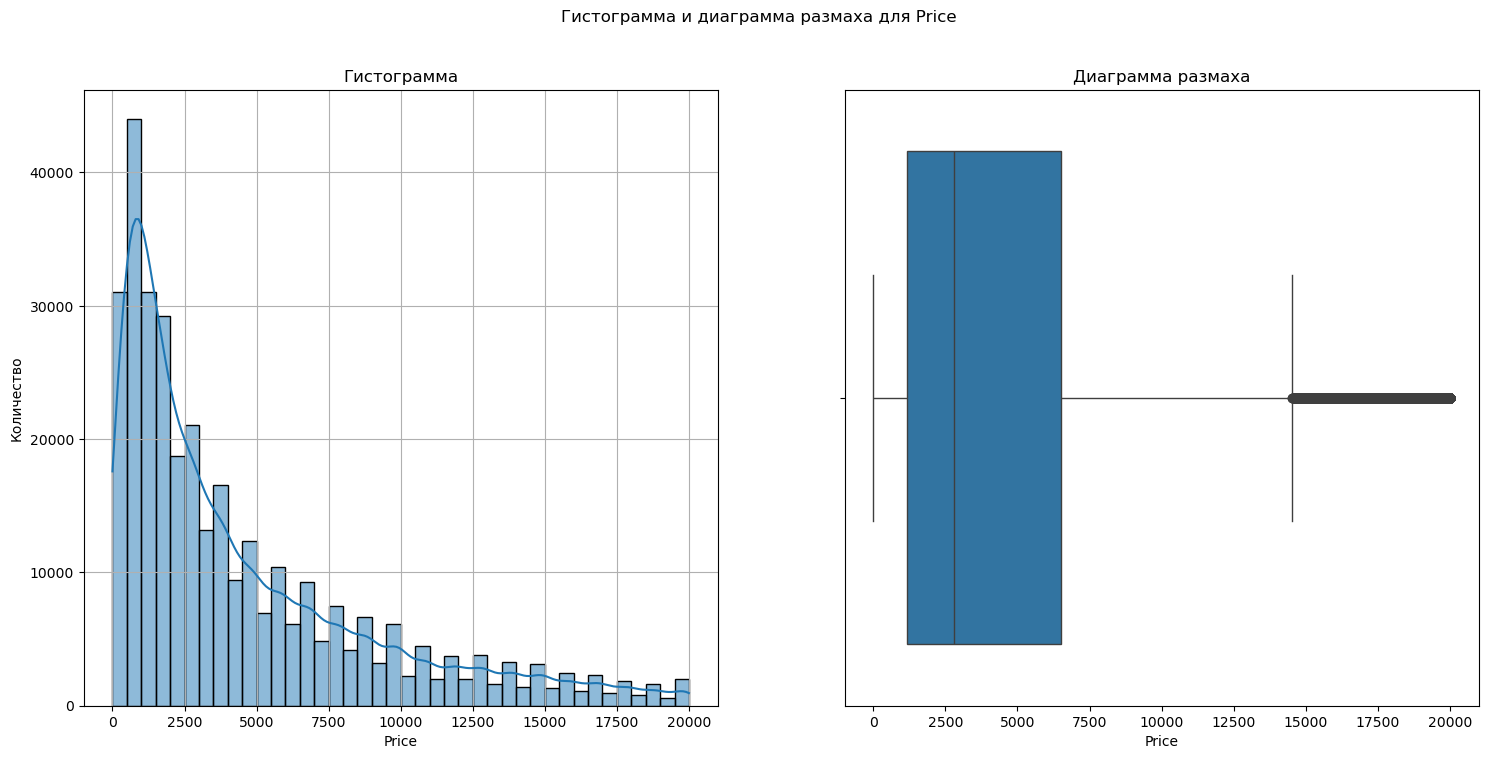

count    334575.000000
mean       4504.160206
std        4531.426312
min           0.000000
25%        1150.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64


In [18]:
hist_box(auto_data,'Price')

Удалим автомобили с ценой менее 10, так как такие машины, вероятно, можно считать практически бесплатными и не представляющими реальной ценности на рынке.

In [19]:
auto_data = auto_data[(auto_data['Price']>=10)]

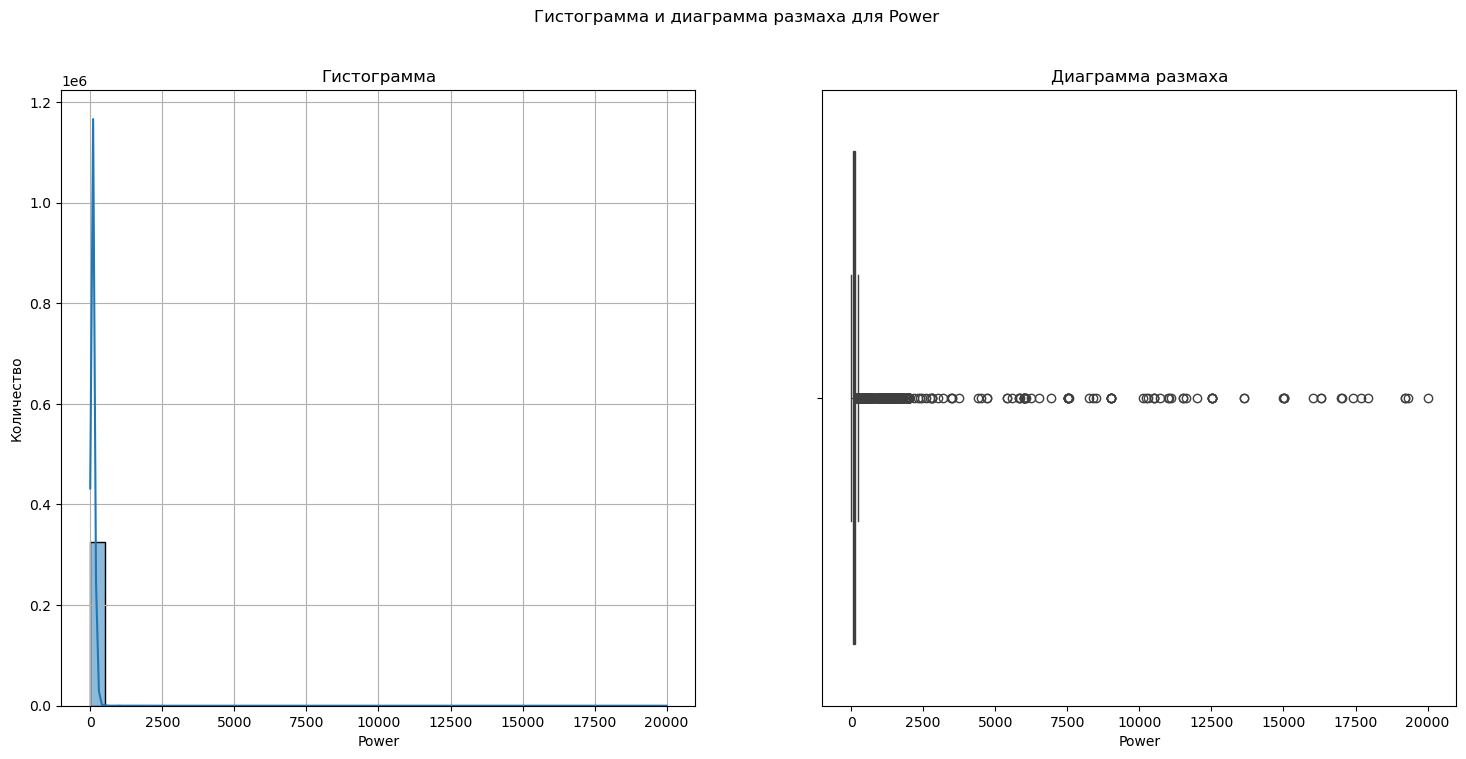

count    325007.000000
mean        112.044362
std         182.951181
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64


In [20]:
hist_box(auto_data,'Power')

На сегодняшний день мощность двигателей не превышает 500 лошадиных сил. Поэтому значения выше 500 будем считать опечаткой и заменим средним значением числа лошадинных сил для машины, найденном в открытых источниках - 120 л.с.

In [21]:
auto_data.loc[auto_data['Power'] > 500, 'Power'] = 120

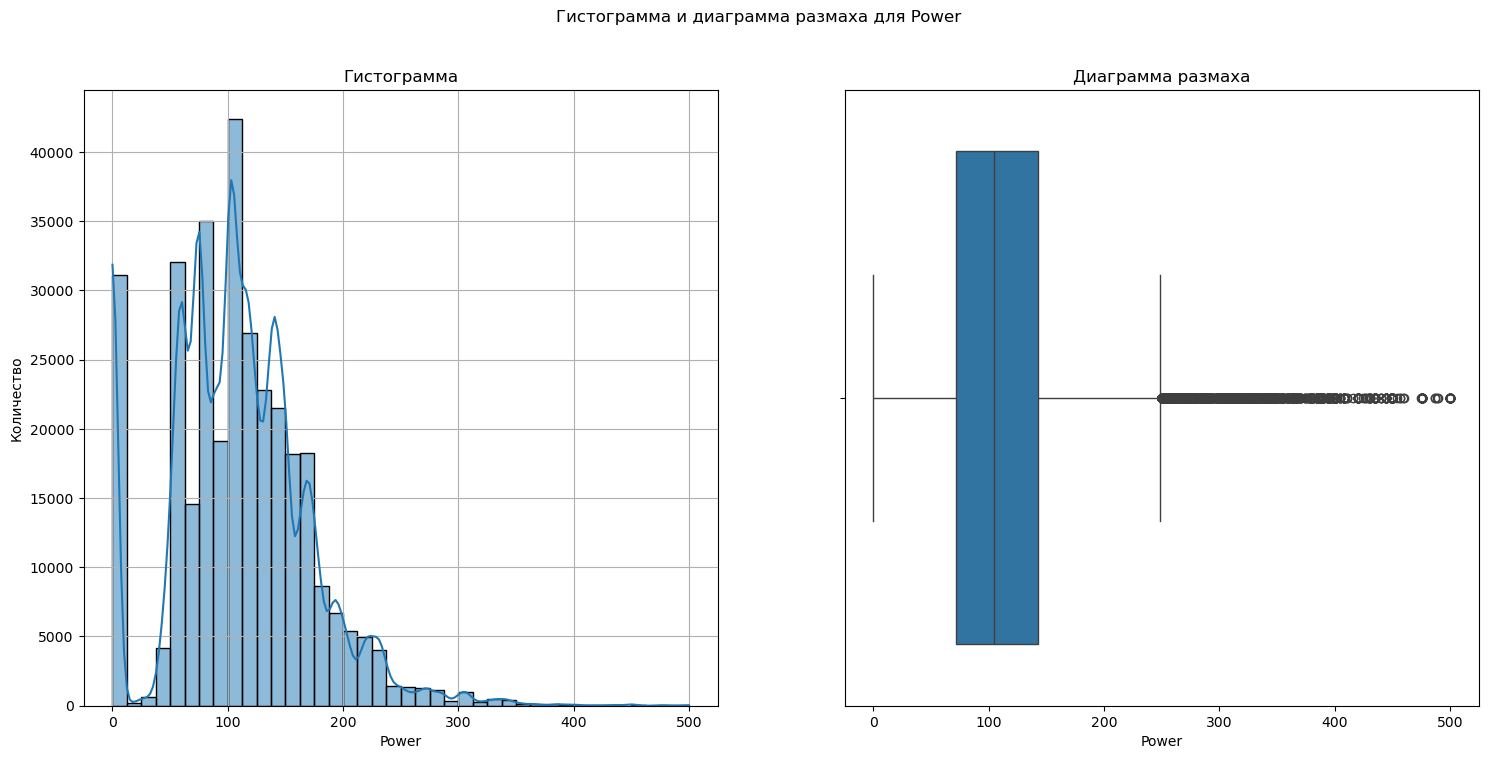

count    325007.000000
mean        108.697080
std          61.516061
min           0.000000
25%          72.000000
50%         105.000000
75%         143.000000
max         500.000000
Name: Power, dtype: float64


In [22]:
hist_box(auto_data,'Power')

Значение мощности двигателя, равное нулю, удалим, так как вероятно, это машины без двигателя, продающиеся на запчасти, для нашего случая такие нерелевантны.

In [23]:
auto_data = auto_data[ (auto_data['Power']!=0)]

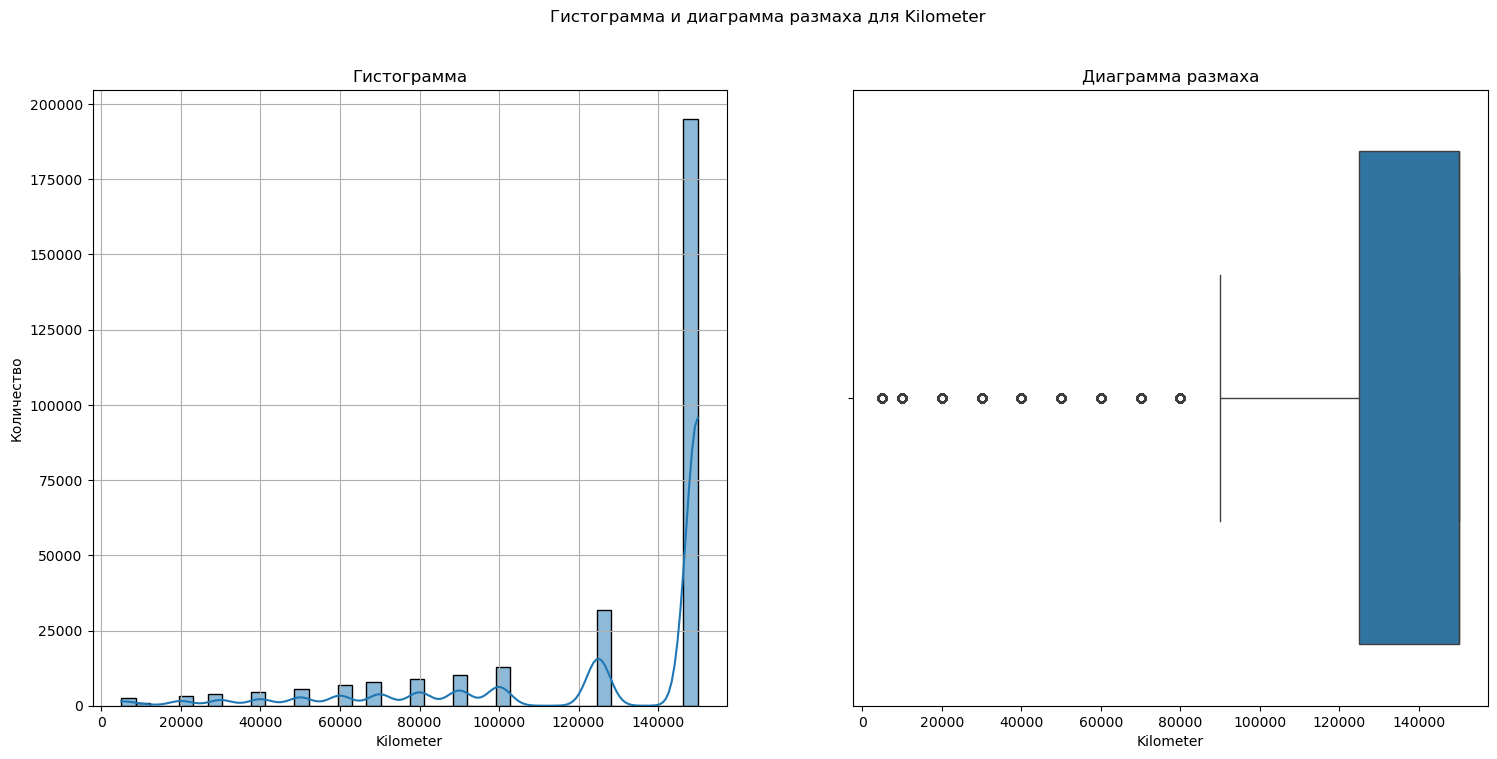

count    294011.000000
mean     128414.838220
std       36565.895777
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: Kilometer, dtype: float64


In [24]:
hist_box(auto_data,'Kilometer')

Данные по пробегу вылядят корректными, ничего менять не будем.

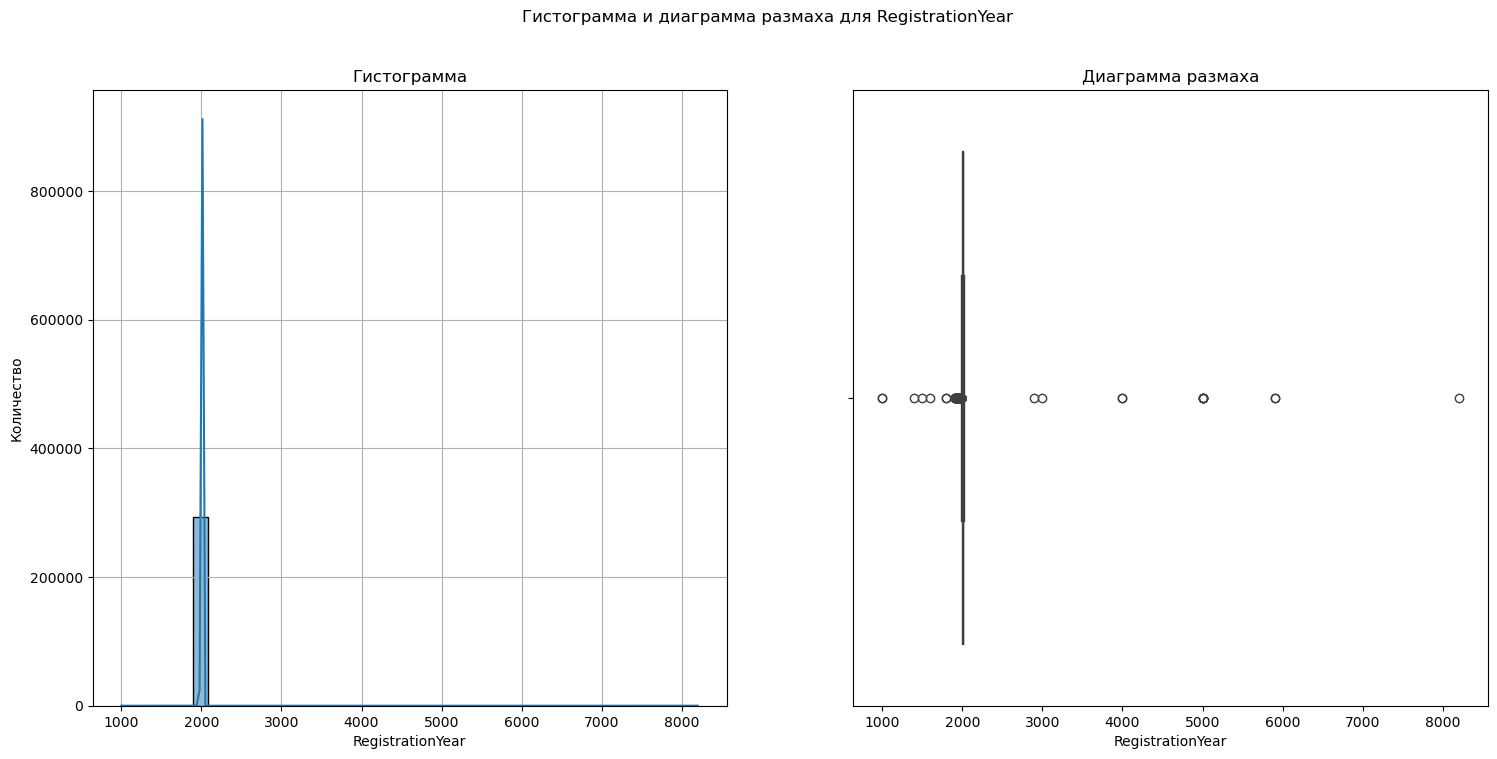

count    294011.000000
mean       2003.470013
std          21.812622
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        8200.000000
Name: RegistrationYear, dtype: float64


In [25]:
hist_box(auto_data,'RegistrationYear') 

Заменим некорректные значения модой, так как присутствующие в данном столбце выбросы по смыслу не могут быть частью реального распределения, то замена на моду может быть более уместной.

In [26]:
# Вычисляем моду
mode_value = auto_data['RegistrationYear'].mode()[0]

# Заменяем некорректные значения
auto_data['RegistrationYear'] = auto_data['RegistrationYear'].apply(
    lambda x: mode_value if x < 1985 or x > 2024 else x
)

**Проанализируем качественные признаки**

In [27]:
def bar_plot(df, column):
    plt.figure(figsize=(14, 6))
    ax = sn.countplot(x=column, data=df)

    total = len(df) 
    for p in ax.patches:
        height = p.get_height()  # Высота столбца
        percentage = (height / total) * 100  # Вычисление процента
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom')

    plt.title(f'Столбчатая диаграмма для {column}')
    plt.xlabel(f'Значения {column}')
    plt.ylabel('Количество наблюдений')
    plt.grid(True)
    plt.show()

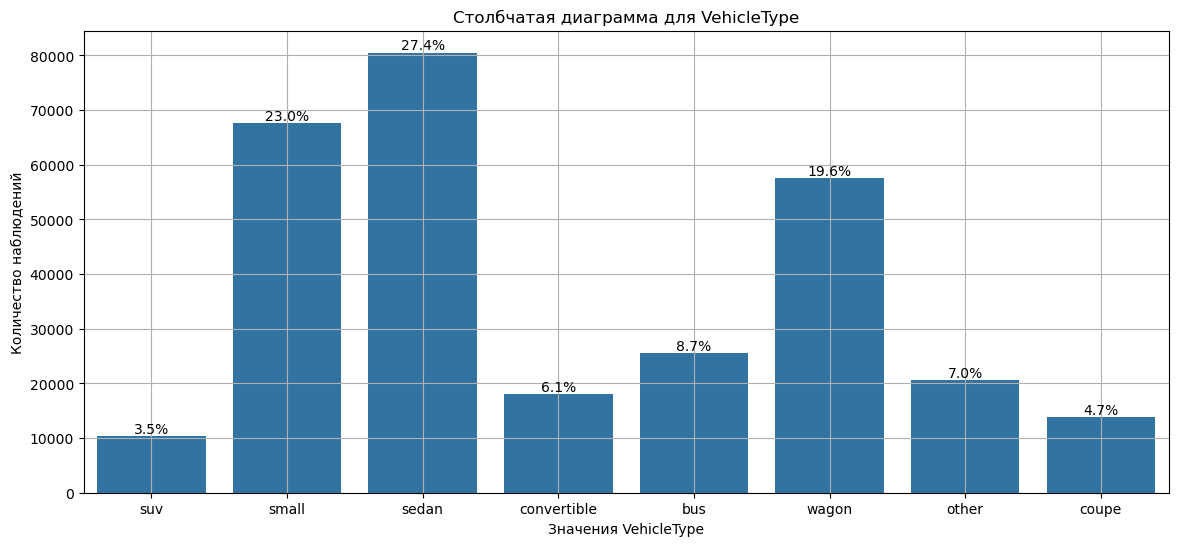

In [28]:
bar_plot(auto_data,'VehicleType')

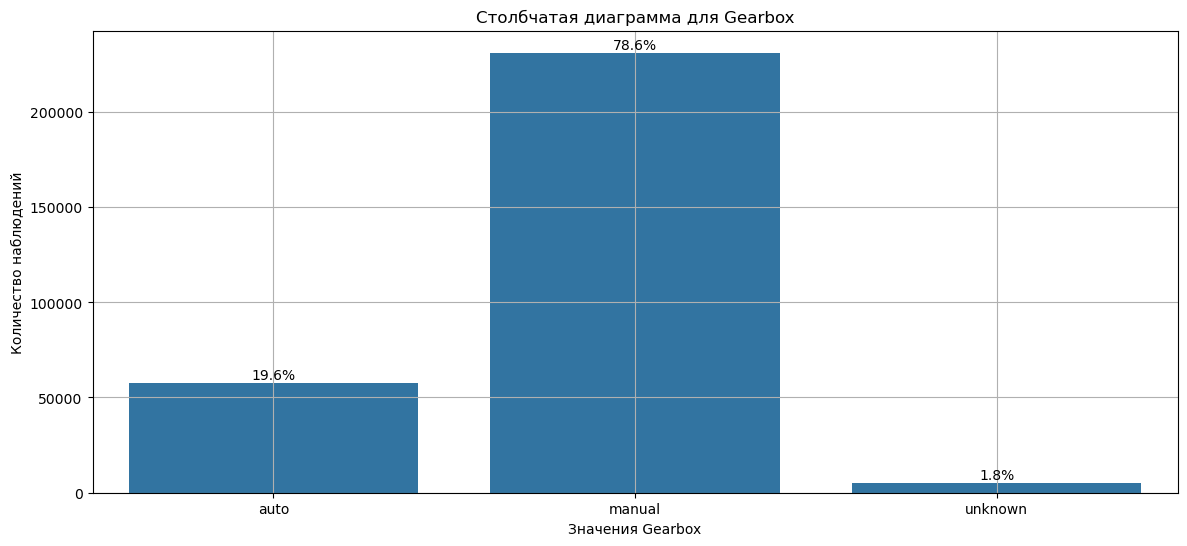

In [29]:
bar_plot(auto_data,'Gearbox')

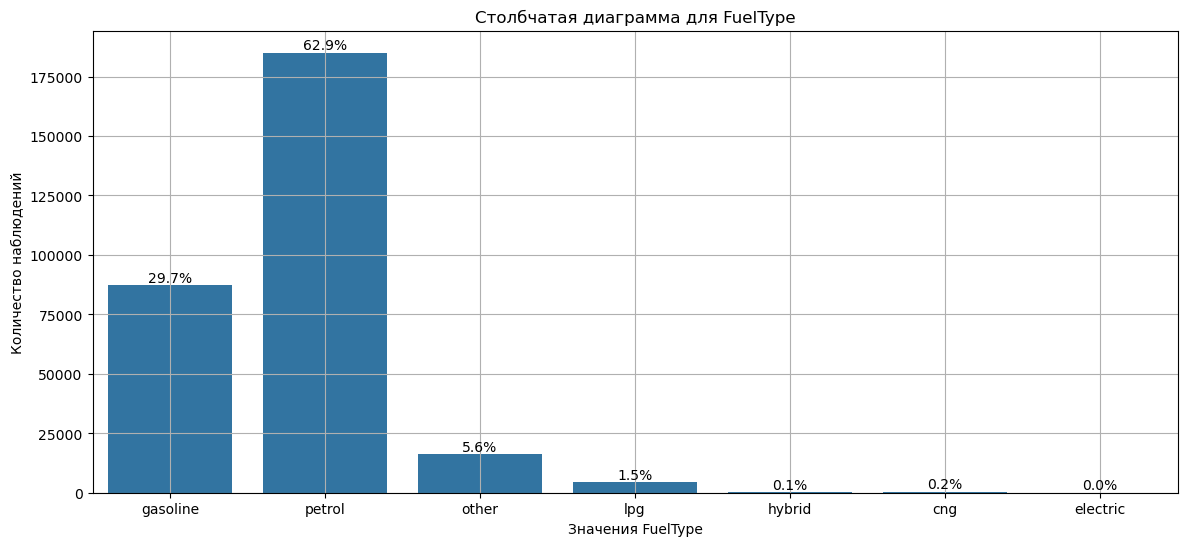

In [30]:
bar_plot(auto_data,'FuelType')

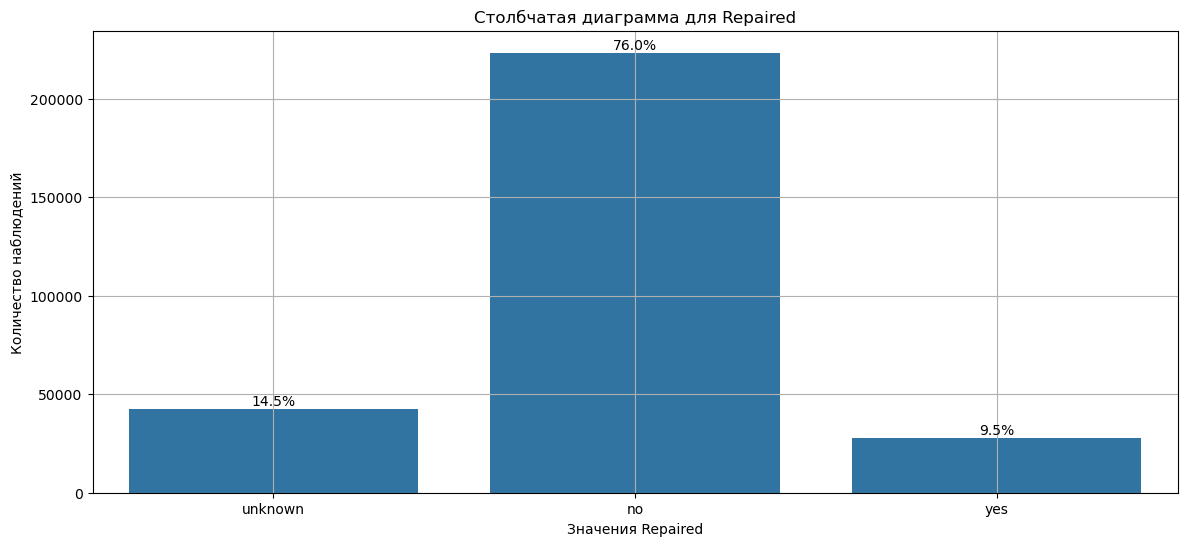

In [31]:
bar_plot(auto_data,'Repaired')

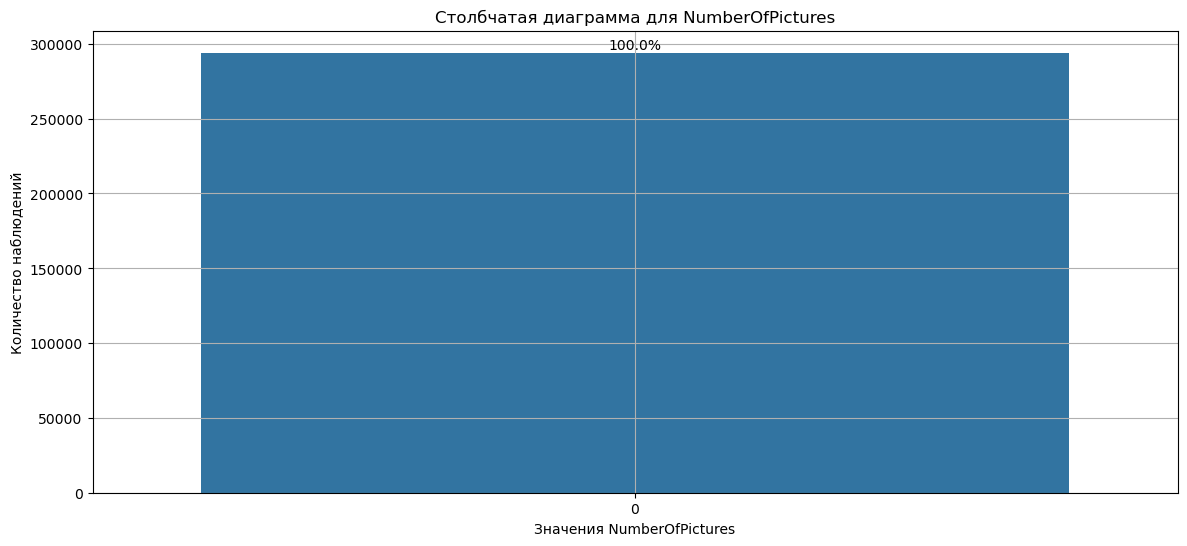

In [32]:
 bar_plot(auto_data,'NumberOfPictures')

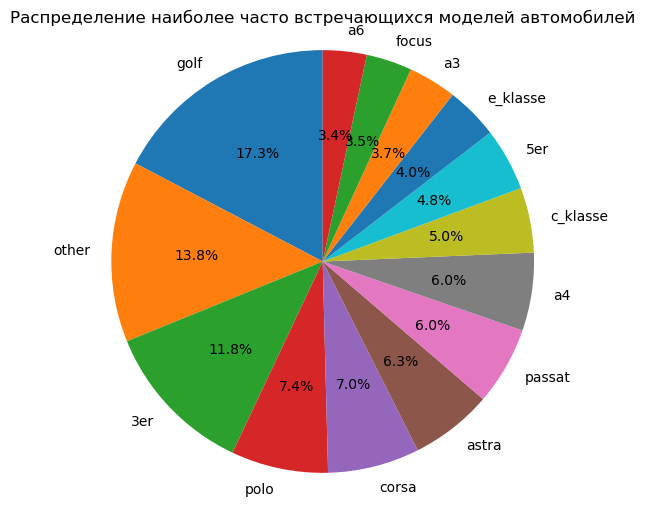

In [33]:
model_counts = auto_data['Model'].value_counts()
model_counts = model_counts[model_counts >= 5000]
plt.figure(figsize=(6, 6))
# Создаем круговую диаграмму
pie_chart = model_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', legend=False)
plt.title('Распределение наиболее часто встречающихся моделей автомобилей')
plt.axis('equal') 

plt.show()

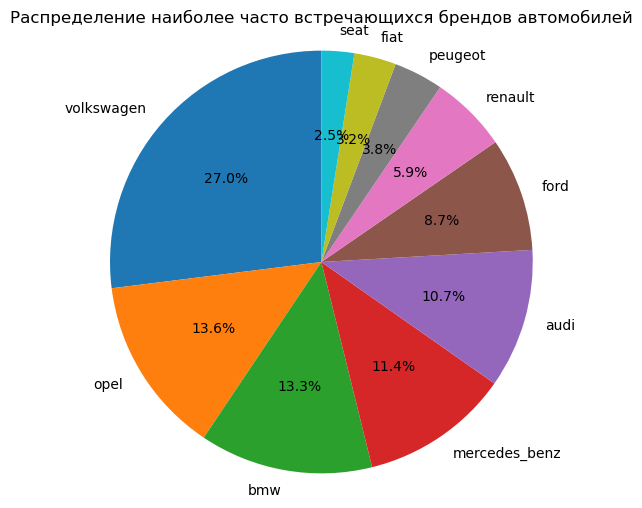

In [34]:
brand_counts = auto_data['Brand'].value_counts()
brand_counts = brand_counts[brand_counts >= 5000]
plt.figure(figsize=(6, 6))
# Создаем круговую диаграмму
pie_chart = brand_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ylabel='', legend=False)
plt.title('Распределение наиболее часто встречающихся брендов автомобилей')
plt.axis('equal') 

plt.show()

Число фотографий равно нулю, столбец неинформативен.

Остальные признаки в столбцах 'DateCrawled','DateCreated',	'NumberOfPictures',	'PostalCode',	'LastSeen' нерелевантны.

**Подготовим датафрейм для следующего шага:**

In [35]:
auto_data = auto_data.drop(['DateCrawled', 'DateCreated', 'RegistrationMonth', 'PostalCode', 'NumberOfPictures', 'LastSeen'], axis=1)

**Проведем корреляционный анализ признаков.**

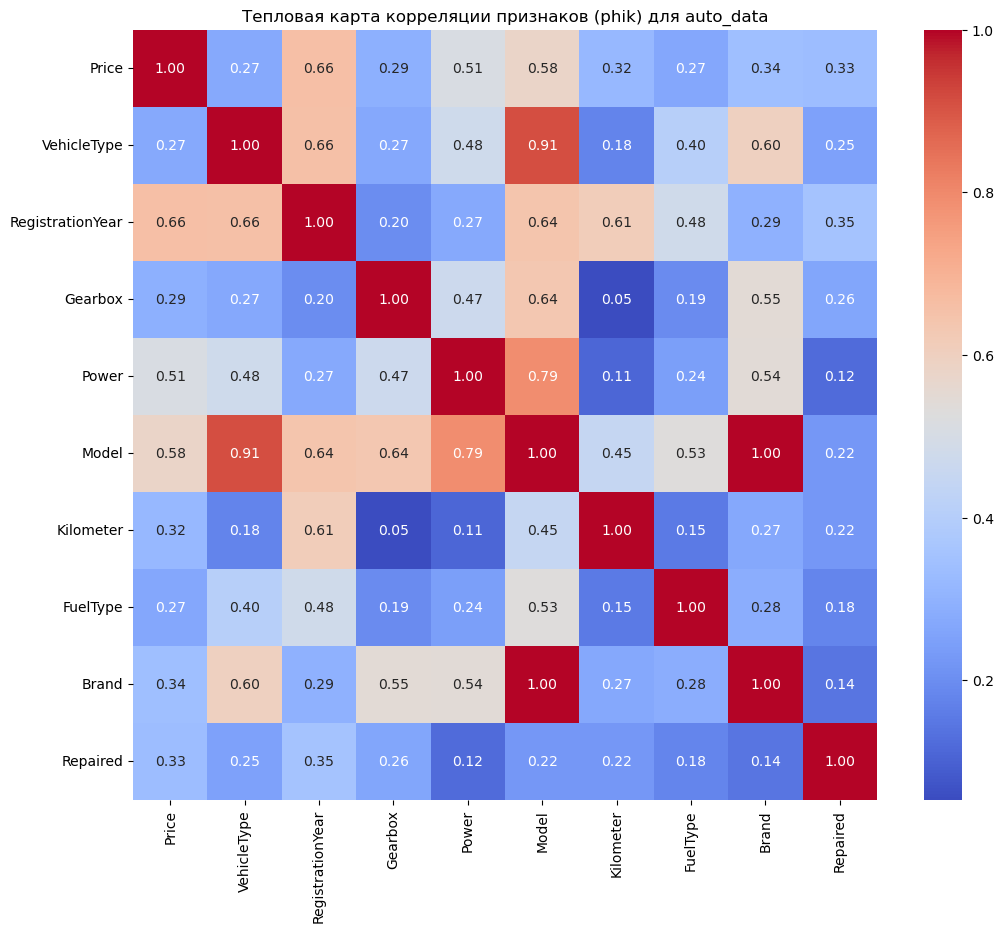

In [36]:
phik_corr = auto_data.phik_matrix(interval_cols = ['Price','Power','Kilometer']) 
plt.figure(figsize=(12, 10))
sn.heatmap(phik_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Тепловая карта корреляции признаков (phik) для auto_data')
plt.show()

Между признаками наблюдается:


Сильная корреляция (значения выше 0.7):

* 1 - 'Model' и 'Brand'
* 0.91 - 'Model' и 'VehicleType'
* 0.79 - 'Model' и 'Power'
* 0.7 - 'RegistrationYear' и 'Price'

Умеренная корреляция (значения от 0.4 до 0.7):

* 0.64 - 'Model' и 'Gearbox'
* 0.62 - 'Model' и 'RegistrationYear'
* 0.6 - 'Brand' и 'VehicleType'
* 0.58 - 'Model' и 'Price'
* 0.55 - 'RegistrationYear' и 'VehicleType'
* 0.55 - 'Power' и 'Gearbox'
* 0.53 - 'Brand' и 'Gearbox'
* 0.5 - 'Brand' и 'Power'
* 0.47 - 'Power' и 'VehicleType'
* 0.47 - 'Kilometer' и 'RegistrationYear'
* 0.44 - 'Repaired' и 'Gearbox'
* 0.42 - 'FuelType' и 'VehicleType'



Слабая корреляция или отсутствие корреляции для остальных признаков.

Между 'Model' и 'Brand' наблюдается стопроцентная корреляция. Удалим признак 'Brand', так как он менее значим для целевого признака.

In [37]:
auto_data = auto_data.drop('Brand', axis=1)
auto_data = auto_data.reset_index(drop=True)
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294011 entries, 0 to 294010
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             294011 non-null  int64 
 1   VehicleType       294011 non-null  object
 2   RegistrationYear  294011 non-null  int64 
 3   Gearbox           294011 non-null  object
 4   Power             294011 non-null  int64 
 5   Model             294011 non-null  object
 6   Kilometer         294011 non-null  int64 
 7   FuelType          294011 non-null  object
 8   Repaired          294011 non-null  object
dtypes: int64(4), object(5)
memory usage: 20.2+ MB


Для оптимизации использования ресурсов мы преобразуем типы данных, заменяя int64 на int32 и int16, что позволит сэкономить память и повысить производительность.

In [38]:
auto_data[['Price', 'RegistrationYear', 'Power']] = auto_data[['Price', 'RegistrationYear', 'Power']].astype('int32')
auto_data['Kilometer'] = auto_data['Kilometer'].astype('int32')

In [39]:
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294011 entries, 0 to 294010
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             294011 non-null  int32 
 1   VehicleType       294011 non-null  object
 2   RegistrationYear  294011 non-null  int32 
 3   Gearbox           294011 non-null  object
 4   Power             294011 non-null  int32 
 5   Model             294011 non-null  object
 6   Kilometer         294011 non-null  int32 
 7   FuelType          294011 non-null  object
 8   Repaired          294011 non-null  object
dtypes: int32(4), object(5)
memory usage: 15.7+ MB


**Вывод: Была выполнена предобработка данных. Проведен исследовательский анализ данных, в данных обработаны выбросы. Исключены нерелевантные столбцы. Между 'Model' и 'Brand' найдена стопроцентная корреляция, поэтому признак 'Brand' был удален.**

## Обучение моделей

### Подготовим выборки для обучения моделей.

Разобъем данные на обучающую и валидационную выборки 75:25.

In [40]:
RANDOM_STATE = 42

y = auto_data['Price']
X = auto_data.drop(['Price'], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=0.25, 
        random_state=RANDOM_STATE
)

### Обучим первую модель DecisionTreeRegressor с подбором гиперпараметров с помощью RandomizedSearch

In [41]:
ord_columns = ['Repaired', 'Gearbox']
ord_cat_columns = ['Model','VehicleType', 'FuelType']
num_columns = ['RegistrationYear', 'Power','Kilometer']

Создаем пайплайн.

In [42]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord',  
            OrdinalEncoder(
                categories=[
                    ['yes', 'unknown', 'no'],
                    ['manual', 'unknown', 'auto']
                   # ['petrol','gasoline','lpg', 'other', 'hybrid', 'cng', 'electric']
                ], 
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 

ord_cat_pipe = Pipeline(
    [
        (
            'simpleImputer_before_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord_cat',  
            OrdinalEncoder(
                categories='auto', 
                handle_unknown='use_encoded_value', unknown_value=-1
            )
        ),
        (
            'simpleImputer_after_ord', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
) 


In [43]:
data_preprocessor = ColumnTransformer(
    [   ('ord', ord_pipe, ord_columns),
        ('ord_cat', ord_cat_pipe, ord_cat_columns),
        ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
) 

In [44]:
pipe_final= Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [45]:
param_grid = [
    # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(15, 20),
        'models__max_features': range(4, 8),
        'models__min_samples_split': range(10, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    }
    
]

Напишем функцию для расчета метрики.

In [46]:
def rmse_sc(y_true, y_pred):
    mse = np.mean((y_pred - y_true) ** 2)
    return np.sqrt(mse)

In [47]:
rmse_scorer = make_scorer(rmse_sc, greater_is_better=False)

Обучим модель.

In [48]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=rmse_scorer,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [49]:
randomized_search.fit(X_train, y_train)

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [DecisionTreeR...ndom_state=42)], 'models__max_depth': range(15, 20), 'models__max_features': range(4, 8), 'models__min_samples_split': range(10, 15), ...}]"
,n_iter,10
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [50]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', - randomized_search.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ord',
                                                                   OrdinalEncoder(categories=[['yes',
                                                                                               'unknown',
                                                                                               'no'],
                                                                                              ['manual',
                                                                                               'unknown',
                   

Лучшая модель и её параметры: 

DecisionTreeRegressor(max_depth=16, min_samples_split=12, random_state=42))])

Метрика лучшей модели при кросс-валидации: 1889

Условие "Значение метрики RMSE должно быть меньше 2500" выполнено.

Проанализируем важность признаков.

In [51]:
best_model = randomized_search.best_estimator_

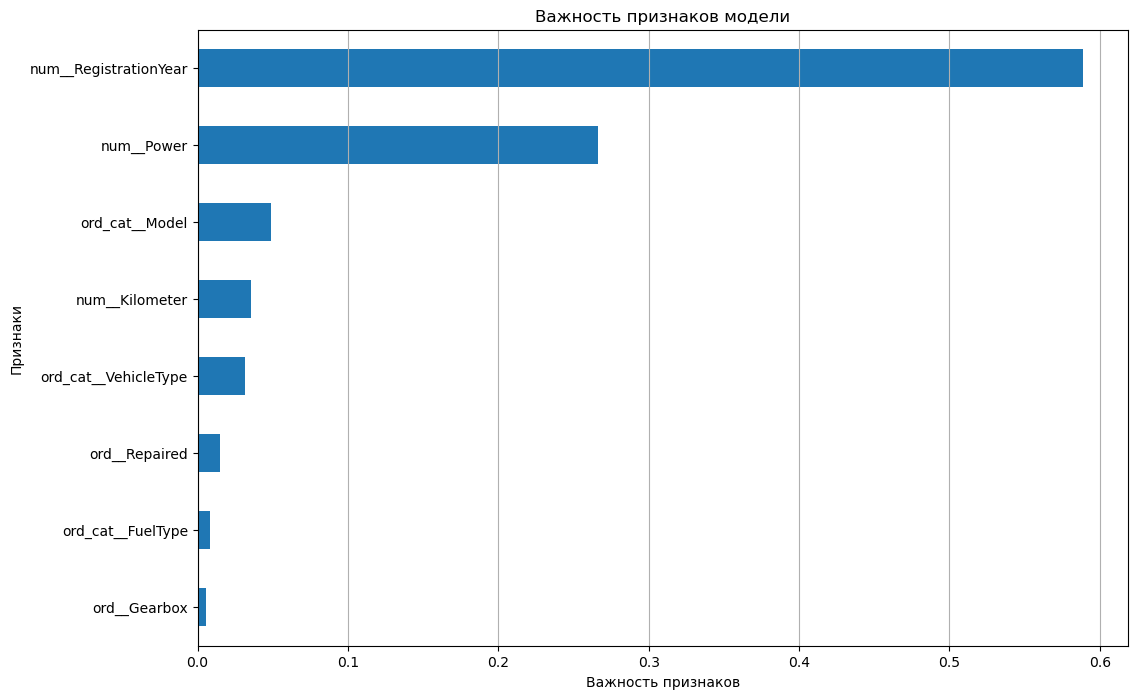

In [52]:
feat_importance = pd.Series(
    best_model[-1].feature_importances_,
    index=best_model[:-1].get_feature_names_out()
)
plt.figure(figsize=(12, 8)) 
# Сортируем значения и строим горизонтальную столбчатую диаграмму
feat_importance.sort_values(ascending=True).plot.barh()

# Добавляем сетку
plt.grid(axis='x')

# Добавляем подписи
plt.xlabel('Важность признаков')
plt.ylabel('Признаки')
plt.title('Важность признаков модели')

# Показываем график
plt.show()

Наиболее важными признаками являются год регистрации, мощность и пробег автомобиля.

### Обучим вторую модель LightGBM

Создадим пайплайн для второй модели.

In [53]:
'''pipe_final_LGBM = Pipeline([
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

param_distributions_LGBM = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 500],
        'models__max_depth': [3, 5, 7, 10]
    }
] 

for column in ohe_columns:
    X_train[column] = X_train[column].astype('category')

randomized_search_LGBM = RandomizedSearchCV( #LGBMRegressor
    pipe_final_LGBM, 
    param_distributions_LGBM, 
    scoring=rmse_scorer, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search_LGBM.fit(X_train, y_train) '''

"pipe_final_LGBM = Pipeline([\n    ('models', LGBMRegressor(random_state=RANDOM_STATE))\n])\n\nparam_distributions_LGBM = [\n    {\n        'models': [LGBMRegressor(random_state=RANDOM_STATE)],\n        'models__n_estimators': [100, 200, 500],\n        'models__max_depth': [3, 5, 7, 10]\n    }\n] \n\nfor column in ohe_columns:\n    X_train[column] = X_train[column].astype('category')\n\nrandomized_search_LGBM = RandomizedSearchCV( #LGBMRegressor\n    pipe_final_LGBM, \n    param_distributions_LGBM, \n    scoring=rmse_scorer, \n    random_state=RANDOM_STATE,\n    n_jobs=-1\n)\nrandomized_search_LGBM.fit(X_train, y_train) "

In [54]:
for column in ord_columns:
    X_train[column] = X_train[column].astype('category') 
for column in ord_cat_columns:
    X_train[column] = X_train[column].astype('category') 
print(X_train[ord_columns].dtypes)
print(X_train[ord_cat_columns].dtypes)

Repaired    category
Gearbox     category
dtype: object
Model          category
VehicleType    category
FuelType       category
dtype: object


In [55]:
pipe_final_LGBM= Pipeline([
   # ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE))
])

In [56]:
param_distributions_LGBM = [
    {
        'models': [LGBMRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [100, 200, 500],
        'models__max_depth': [3, 5, 7, 10]
    }
] 

In [57]:
randomized_search_LGBM = RandomizedSearchCV( #LGBMRegressor
    pipe_final_LGBM, 
    param_distributions_LGBM, 
    scoring=rmse_scorer, 
    random_state=RANDOM_STATE,
    n_jobs=-1
)


In [58]:
randomized_search_LGBM.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 220508, number of used features: 8
[LightGBM] [Info] Start training from score 4868.128004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"[{'models': [LGBMRegressor(random_state=42)], 'models__max_depth': [3, 5, ...], 'models__n_estimators': [100, 200, ...]}]"
,n_iter,10
,scoring,make_scorer(r...hod='predict')
,n_jobs,-1
,refit,True
,cv,None
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


Лучшие параметры для LGBMRegressor: max_depth=10, n_estimators=500, random_state=42.

In [59]:
print('Лучшая модель и её параметры:\n\n', randomized_search_LGBM.best_estimator_)
print ('Метрика лучшей модели при кросс-валидации:', - randomized_search_LGBM.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('models',
                 LGBMRegressor(max_depth=10, n_estimators=500,
                               random_state=42))])
Метрика лучшей модели при кросс-валидации: 1579.1921454685094


Условие "Значение метрики RMSE должно быть меньше 2500" выполнено.

**Вывод: Были обучены модели DecisionTreeRegressor и LGBMRegressor, метрика RMSE для первой модели составила 1883.8, для второй 1579.2. Лучшие параметры для DecisionTreeRegressor: max_depth=16, min_samples_split=12, random_state=42, а для LGBMRegressor:max_depth=10, n_estimators=500. LGBMRegressor продемонстрировал лучшую производительность по метрике RMSE, что делает его предпочтительным выбором для данной задачи.**

## Анализ моделей

### Проанализируем время обучения, время предсказания и качество моделей.

**Сравним качество предсказаний моделей**

Метрика лучшей модели DecisionTreeRegressor при кросс-валидации из п 2.2:

In [60]:
RMSE_DTR=1889

Метрика лучшей модели  LGBMRegressor при кросс-валидации из п.2.3: 

In [61]:
RMSE_LGBM=1579

**Сравним время обучения моделей**

Замерим время обучения и предсказания для лучшей модели DecisionTreeRegressor

In [62]:
model_DTR = Pipeline([
    ('preprocessor', data_preprocessor),
    ('model', DecisionTreeRegressor(max_depth=16, min_samples_split=12, random_state=RANDOM_STATE)) # параметры лучшей модели
])

In [63]:
start_time = time.time()
model_DTR.fit(X_train, y_train)
end_time = time.time()
fitting_time_DTR = end_time - start_time
print(f"Время обучения fitting_time_DTR: {fitting_time_DTR:.4f} секунд")

Время обучения fitting_time_DTR: 1.5339 секунд


In [64]:
start_time = time.time()
y_pred = model_DTR.predict(X_test)
end_time = time.time()
execution_time_DTR = end_time - start_time
print(f"Время предсказания execution_time_DTR: {execution_time_DTR:.4f} секунд")

Время предсказания execution_time_DTR: 0.1407 секунд


Замерим время обучения и предсказания для лучшей модели LGBMRegressor

In [65]:
for column in ord_columns:
    X_train[column] = X_train[column].astype('category')
    X_test[column] = X_test[column].astype('category')
for column in ord_cat_columns:
    X_train[column] = X_train[column].astype('category')
    X_test[column] = X_test[column].astype('category')

In [66]:
model_LGBM = Pipeline([
    ('models', LGBMRegressor(max_depth=10, n_estimators=500, random_state=RANDOM_STATE))#, force_row_wise=True)) # параметры лучшей модели
])

In [67]:
start_time = time.time()
model_LGBM.fit(X_train, y_train)
end_time = time.time()
fitting_time_LGBM = end_time - start_time
print(f"Время обучения fitting_time_LGBM: {fitting_time_LGBM:.4f} секунд")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 537
[LightGBM] [Info] Number of data points in the train set: 220508, number of used features: 8
[LightGBM] [Info] Start training from score 4868.128004
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Время обучения fitting_time_LGBM: 3.2623 секунд


In [68]:
start_time = time.time()
y_pred = model_LGBM.predict(X_test)
end_time = time.time()
execution_time_LGBM = end_time - start_time
print(f"Время предсказания execution_time_LGBM: {execution_time_LGBM:.4f} секунд")

Время предсказания execution_time_LGBM: 0.9345 секунд


In [69]:
models_pivot = {
    'fitting_time': [fitting_time_DTR, fitting_time_LGBM],
    'predict_time': [execution_time_DTR, execution_time_LGBM],
    'rmse': [RMSE_DTR, RMSE_LGBM]
}
models_pivot = pd.DataFrame(models_pivot, index=['DTR', 'LGBM'])
models_pivot = models_pivot.style.set_caption("<b>Сравнительный анализ работы моделей</b>")
models_pivot

,fitting_time,predict_time,rmse
DTR,1.533919,0.140659,1889
LGBM,3.262285,0.934502,1579


**Анализ эффективности моделей:**

   • **Скорость обучения:** LGBM медленнее обучается по сравнению с DTR (2.8 секунд против 1.2 секунд). DecisionTreeRegressor строит одно дерево решений, что обычно требует меньше вычислительных ресурсов и времени. LightGBM, с другой стороны, использует метод градиентного бустинга, который строит множество деревьев последовательно, где каждое новое дерево пытается исправить ошибки предыдущих. Это делает процесс более сложным и времязатратным.

   • **Скорость предсказания:** Время предсказания для LGBM больше (0.98 секунд против 0.12 секунд), это может быть обусловлено сложностью модели.

   • **Точность:** LGBM обеспечивает более точные предсказания стоимости автомобилей, так как LGBM имеет более низкое значение RMSE (1579) по сравнению с DTR (1889).

На основании анализа, модель LightGBM выглядит более предпочтительной для задачи определения рыночной стоимости автомобилей с пробегом, благодаря своей точности.

### Проверим на тестовой выборке качество предсказаний выбранной модели.

In [70]:
RMSE_LGBM = rmse_sc(y_test, y_pred).round(1)
print('RMSE модели LGBM на тестовых данных RMSE_LGBM:', RMSE_LGBM)

RMSE модели LGBM на тестовых данных RMSE_LGBM: 1583.8


**Вывод:** 
**Для разработки приложения были созданы, обучены и проанализированы модели определения рыночной стоимости автомобилей с пробегом DecisionTreeRegressor и LightGBM.** 

**LightGBM показала более высокую точность, при этом по времени обучения и предсказания она уступила модели DecisionTreeRegressor. Выбор LightGBM в качестве предпочтительной модели обоснован его способностью обеспечивать более высокую точность предсказаний, что подтверждается более низким значением RMSE (1579) по сравнению с DecisionTreeRegressor (1889).** 

**Несмотря на то, что LGBM требует больше времени на обучение и предсказание, она больше подходит для задач, где качество предсказаний имеет первостепенное значение.**

**RMSE модели LGBM на тестовых данных RMSE_LGBM: 1583.8**